In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
import scipy

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

# Not imputed
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Imputed
Xi_median = pd.read_csv("data/imputed/median_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_knn = pd.read_csv("data/imputed/knn_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t").rename(columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [4]:
# Clusters from consensus cluster plus
ccp_cluster_df = pd.read_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t", index_col=0)[["cluster","itemConsensus"]].dropna()
ccp_cluster_df["cluster"] = ccp_cluster_df["cluster"].astype(int).astype(str)

In [5]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).join(ccp_cluster_df['cluster']).drop(columns=to_drop).dropna()
).join(data_df[["time","status"]])

Using 29 quantitative variables.
Using 35 categorical variables.
Total samples x feaures (one-hot encoded): (1601 x 76)


### 2. Survival Predictons
---

In [6]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from itertools import chain

In [40]:
# Initial model just with quantitative variables
test_size = 0.25

# Random state
RANDOM_STATE = 122

# Dictionaries for storage
models = dict()
risk_scores = dict()
aucs = dict()
mean_aucs = dict()

# Time predictiosn for AUC
x_times = range(2,250,5)

In [ ]:
# Generate outcome 
y = Xi_mice_bu_df.loc[:,['status','time']]
y.loc[:,'status'] = y['status'].replace({1:True,0:False})
y = np.array(list(y.to_records(index=False)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(Xi_mice_bu_df.drop(columns=['time','status']), y, test_size=test_size, random_state=RANDOM_STATE)

print("Train size (n={})".format(X_train.shape[0]))
print("Test size (n={})".format(X_test.shape[0]))

#### 2a. Baseline Cox Regression Models
---

In [41]:
# Cox Model #1
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph"] = CoxPHSurvivalAnalysis()
models["cph"].fit(X_train[vars_to_use], y_train)

# Cox Model #2
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage + cluster
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)","cluster"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph2"] = CoxPHSurvivalAnalysis()
models["cph2"].fit(X_train[vars_to_use], y_train)

# Cox Model #3
# Surv ~ BU Stage
numerical_vars = []
categorical_vars = ["BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph3"] = CoxPHSurvivalAnalysis()
models["cph3"].fit(X_train[vars_to_use], y_train)

CoxPHSurvivalAnalysis()

#### 2b. Random Survival Forest
---

In [19]:
cluster_vars = []

for x in X_train.columns:
    if "BU" in x or "cluster" in x:
        cluster_vars.append(x)

cluster_vars

['cluster=2',
 'cluster=3',
 'BU Stage (Computed)=stage II',
 'BU Stage (Computed)=stage III',
 'BU Stage (Computed)=stage IIIb']

In [47]:
# Initial RSF model, no hyperparameter search
models["rsf"] = RandomSurvivalForest(
    n_estimators=10, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=RANDOM_STATE
)

# Fit Model
models["rsf"].fit(X_train.drop(columns=cluster_vars), y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=122)

### 3. Comparing Model Performance
---

In [48]:
for key, _ in models.items():
    # Predictions on Test Set
    print("Resutls for: model {}".format(key))
    print("  * C-statistic (Train): ", models[key].score(X_train.loc[:,models[key].feature_names_in_], y_train))
    print("  * C-statistic (Test): ", models[key].score(X_test.loc[:,models[key].feature_names_in_], y_test))

    # Predictions
    risk_scores[key] = models[key].predict(X_test.loc[:,models[key].feature_names_in_])
    aucs[key], mean_aucs[key] = cumulative_dynamic_auc(y_train, y_test, risk_scores[key], x_times)

Resutls for: model cph
  * C-statistic (Train):  0.7033329440717625
  * C-statistic (Test):  0.6906285667699331
Resutls for: model cph2
  * C-statistic (Train):  0.7120264524863001
  * C-statistic (Test):  0.702735203000163
Resutls for: model cph3
  * C-statistic (Train):  0.652424018303944
  * C-statistic (Test):  0.6436389205935105
Resutls for: model rsf
  * C-statistic (Train):  0.8052589238215105
  * C-statistic (Test):  0.7283548018914071


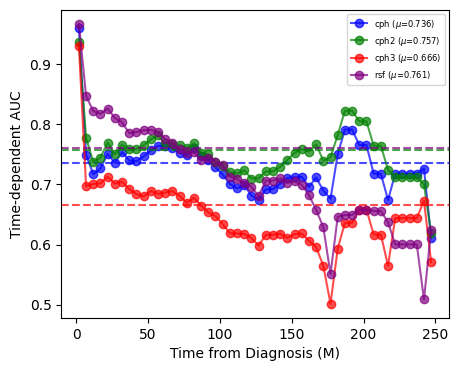

In [53]:
fig, ax = plt.subplots(figsize=(5,4))

colors = ["b","g","r","purple"]

for idx,(key, _) in enumerate(models.items()):
    ax.plot(x_times, aucs[key], marker="o", c=colors[idx], label="{} ($\mu$={:.3})".format(key, mean_aucs[key]), alpha=0.7)
    ax.axhline(mean_aucs[key], linestyle="--", c=colors[idx], alpha=0.7)

ax.set_xlabel("Time from Diagnosis (M)")
ax.set_ylabel("Time-dependent AUC")
#ax.grid(True)
ax.legend(fontsize=6)

plt.savefig("figures/test_timedep_auc_plot.pdf", dpi=200, bbox_inches="tight")

### 4. Feature Importance to Survival
---

In [58]:
import shap
from tqdm import tqdm

shap_explainers = dict()
shap_values = dict()

In [59]:
for key,_ in tqdm(models.items()):
    shap_explainers[key] = shap.Explainer(models[key].predict, X_train.loc[:,models[key].feature_names_in_])
    shap_values[key] = shap_explainers[key](X_test.loc[:,models[key].feature_names_in_])

PermutationExplainer explainer: 402it [00:15, 10.76it/s]                         
PermutationExplainer explainer: 402it [00:12,  5.48it/s]                         
PermutationExplainer explainer: 402it [14:01,  2.12s/it]
100%|██████████| 4/4 [14:30<00:00, 217.72s/it]


In [75]:
X_tes

,Sex=male,Ethnicity=non_hispanic,Race=Black,Race=Other,Race=White,Kappa or lambda PCD=L,Primary organ=cardiac,Primary organ=gi,Primary organ=hepatic,Primary organ=other,...,Troponin,Calcium,Uric acid,LDH,Iron,TIBC,Systolic BP sitting,Diastolic BP sitting,Pulse sitting,Age
2021142,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.039,9.0,3.8,255,68,218,137,81,63,75
2017149,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.324,10.0,7.4,223,95,277,112,75,82,60
2020060,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.049,9.6,8.7,239,31,251,185,62,73,76
2007082,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.350,9.0,5.7,332,21,336,128,76,60,59
2001049,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.163,8.5,5.8,279,86,210,136,86,86,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006117,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.138,9.9,4.6,154,46,284,159,95,91,59
2018006,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.020,10.3,5.3,219,135,317,137,82,66,74
2011055,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.045,9.8,3.2,267,25,361,102,71,98,52
98075,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.065,9.3,10.0,168,51,309,133,84,64,63


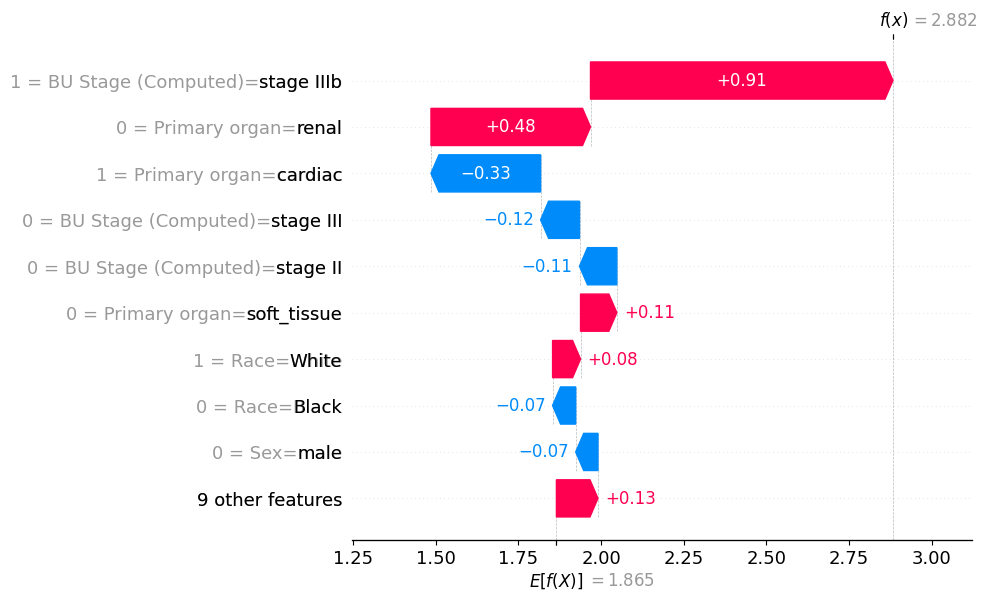

In [76]:
shap.plots.waterfall(shap_values["cph"][3])

In [83]:
shap.plots.beeswarm

<function shap.plots._beeswarm.beeswarm(shap_values, max_display=10, order=shap.Explanation.abs.mean(0), clustering=None, cluster_threshold=0.5, color=None, axis_color='#333333', alpha=1, show=True, log_scale=False, color_bar=True, plot_size='auto', color_bar_label='Feature value')>

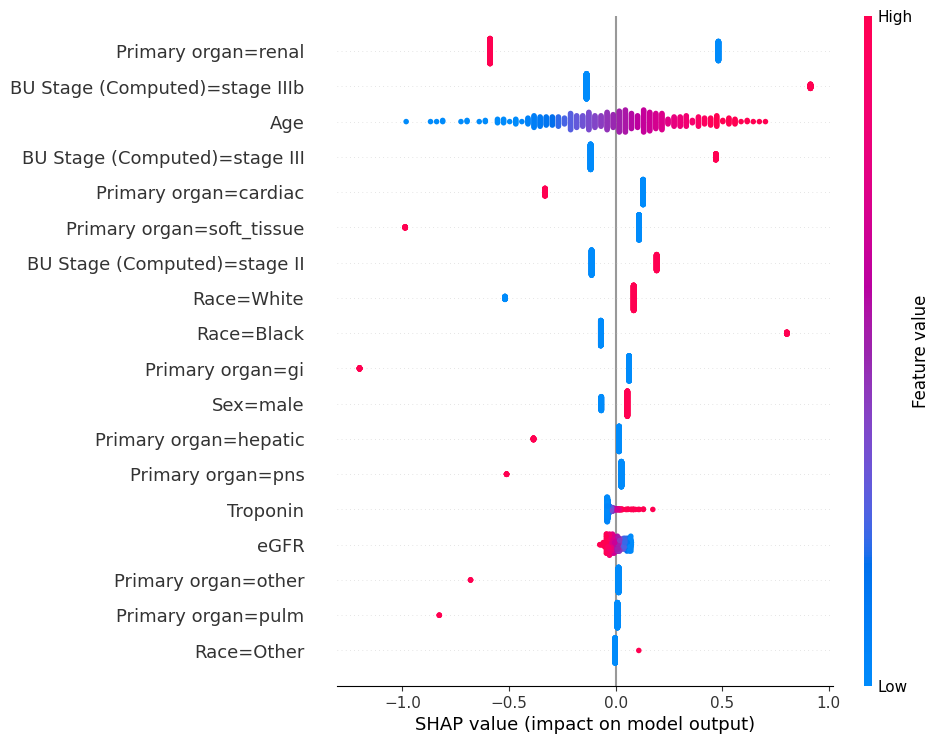

In [84]:
shap.plots.beeswarm(shap_values["cph"], show=False, max_display=30)
plt.savefig("figures/cph1_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

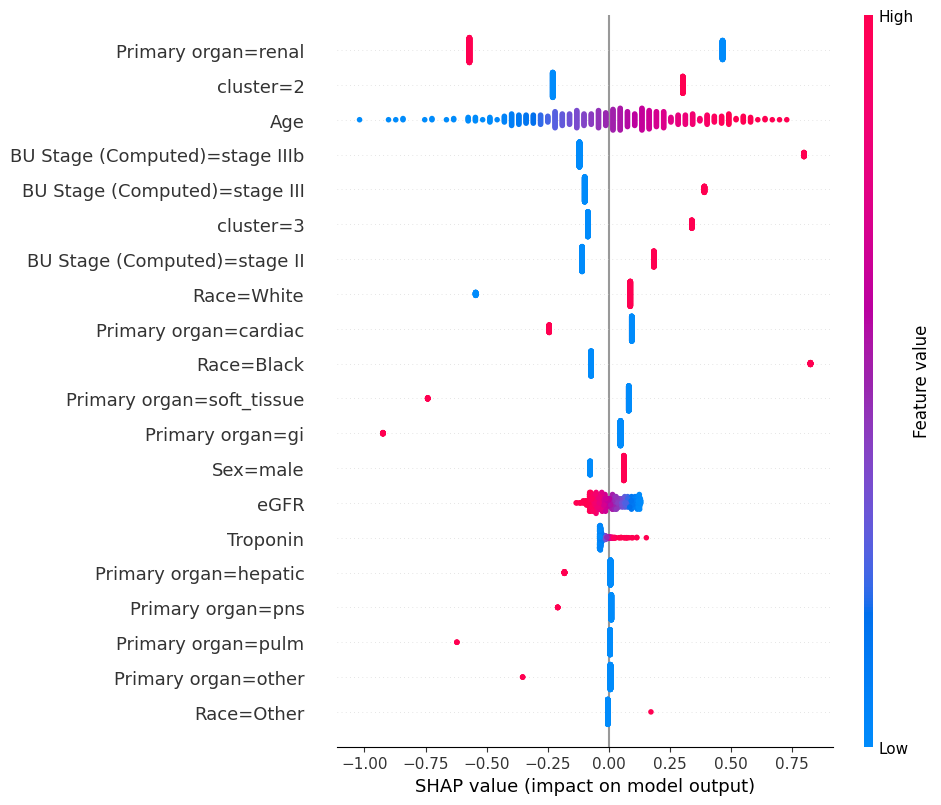

In [85]:
shap.plots.beeswarm(shap_values["cph2"], show=False, max_display=30)
plt.savefig("figures/cph2_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

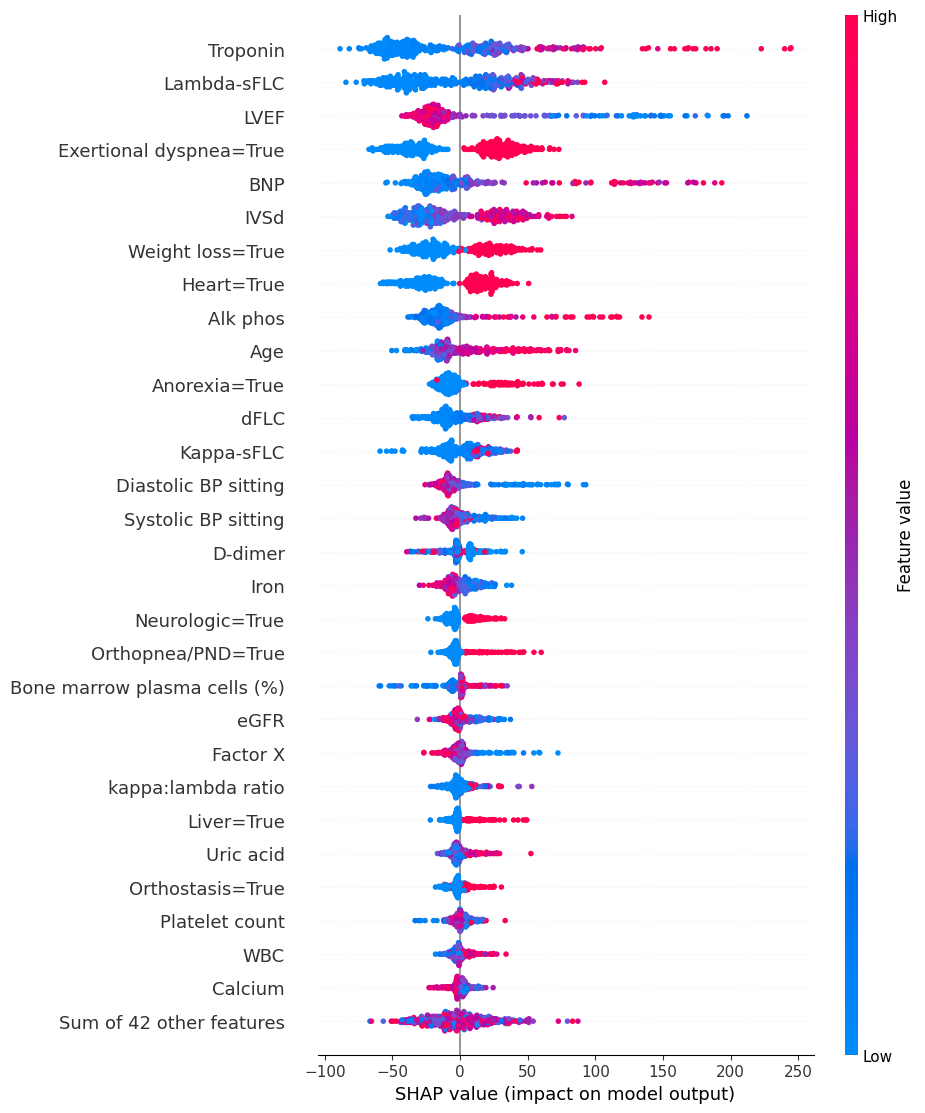

In [86]:
shap.plots.beeswarm(shap_values["rsf"], show=False, max_display=30)
plt.savefig("figures/rsf_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

In [33]:
import importlib; importlib.reload(utils)

df = utils.compute_permutation_importance(rsf, X_test.loc[:,rsf.feature_names_in_], y_test, random_state=RANDOM_STATE)

In [48]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
#explainer = shap.Explainer(rsf.predict, X_train.drop(columns=cluster_vars))
#shap_values = explainer(X_test.drop(columns=cluster_vars))
#shap.Explainer(model_rvr.predict, X)

In [ ]:
shap.plots.beeswarm(

In [51]:
shap.plots.beeswarm

<function shap.plots._beeswarm.beeswarm(shap_values, max_display=10, order=shap.Explanation.abs.mean(0), clustering=None, cluster_threshold=0.5, color=None, axis_color='#333333', alpha=1, show=True, log_scale=False, color_bar=True, plot_size='auto', color_bar_label='Feature value')>

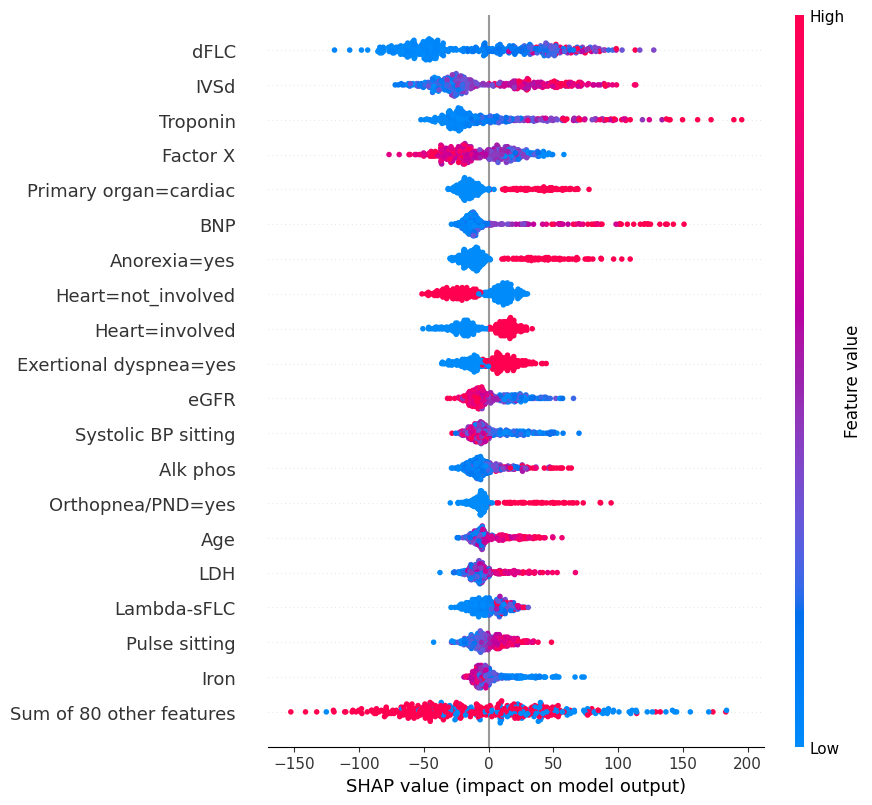

In [52]:
shap.plots.beeswarm(shap_values, max_display=20)

In [20]:
# class DataObject(object):
#     """_summary_

#     Args:
#         object (_type_): _description_
#     """
#     def __init__(self, X: pd.DataFrame, time: str = "time", indicator: str = "status") -> None:
#         """_summary_

#         Args:
#             X (pd.DataFrame): _description_
#             time (str, optional): _description_. Defaults to "time".
#             indicator (str, optional): _description_. Defaults to "status".
#         """
#         from sksurv.preprocessing import OneHotEncoder

#         self.X = X

#         # Select numeric and categorical variables
#         self.X_cat = self.X.loc[:, self.X.dtypes in ["object","category"]].astype("category")
#         self.X_numeric = self.X.loc[:, self.X.dtypes not in  ["object","category"]]

#         # One hot encode categorical variables
#         self.X_cat_onehot = OneHotEncoder().fit_transform(self.X_cat)

#     def __str__(self) -> str:
#         print("Data Object \n \t * {} nategorical variables \n \t * {} numeric variables".format(
#             self.X_cat.shape[0], self.X_numeric.shape[0]))
        
# DataObject(test_df)